<a href="https://colab.research.google.com/github/jae1001/PartII_C1/blob/main/potts_zener_stagnation_cutoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IPython.core.display.Javascript object>


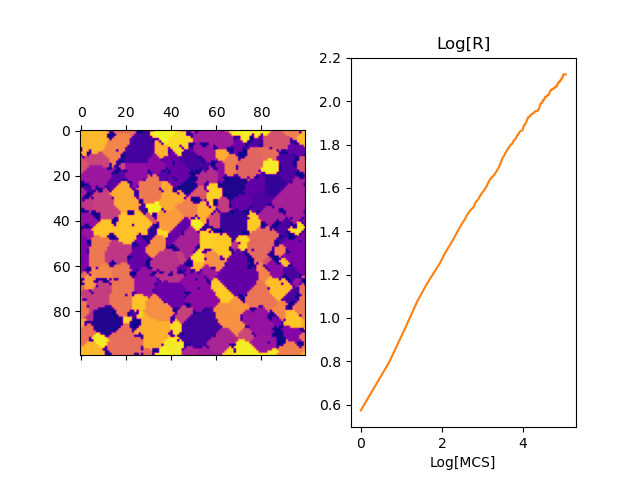

1      3177
2      2045
3      1481
4      1166
5      1000
6      896
7      819
8      741
9      691
10      645
11      603
12      570
13      544
14      517
15      499
16      488
17      464
18      454
19      437
20      425
21      415
22      404
23      390
24      378
25      371
26      366
27      360
28      352
29      344
30      337
31      328
32      318
33      308
34      304
35      297
36      292
37      287
38      283
39      278
40      275
41      272
42      271
43      264
44      262
45      260
46      257
47      251
48      250
49      247
50      243
51      242
52      241
53      240
54      239
55      232
56      229
57      228
58      224
59      222
60      218
61      215
62      212
63      212
64      211
65      209
66      208
67      207
68      206
69      205
70      205
71      204
72      203
73      201
74      201
75      201
76      201
77      200
78      200
79      199
80      197
81      196
82      192
83      190
84      

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.optimize as opt
from numba import njit
%matplotlib notebook

def largest_primes_under(N):
    n = N - 1
    while n >= 2:
        if all(n % d for d in range(2, int(n ** 0.5 + 1))):
            return n
        n -= 1

@njit
def Neighbors(Lattice,i,j,n=1):
    ''' Returns an flat array of all neighboring sites in the n-th coordination sphere including the center'''
    N, M = Lattice.shape
    rows = np.array([(i-1) % N, i, (i+1) % N])
    cols = np.array([(j-1) % N, j, (j+1) % M])
    return Lattice[rows,:][:,cols].flatten()

@njit
def calc_dE(Lattice, x, y, z):
    N, M = Lattice.shape
    old_energy = 0
    new_energy = 0
    for i in [0,1,-1]:
        for j in [0,1,-1]:
            if i == 0 and j == 0:
                continue
            if Lattice[(x+i)%N,(y+j)%M] == 0:
                continue
            if Lattice[x%N,y%M] == Lattice[(x+i)%N,(y+j)%M]:
                old_energy += 1
            elif z == Lattice[(x+i)%N,(y+j)%M]:
                new_energy += 1
    return old_energy-new_energy

@njit
def inject_defects(Lattice):
    N, M = Lattice.shape
    for t in range(1,defect+1):
        index = np.random.randint(N*M)
        x = index % N
        y = index // N
        Lattice[x%N,y%N] = 0
    return Lattice
            
    
N, M = 100,100
f_defect = 0.03125
orientations = N*M
defects = np.rint(orientations*f_defect)
defect = defects.astype(int)

beta = 2.5
MCS = int(500)

a = largest_primes_under(N*M)
P = np.random.randint(1,orientations+1,size=(N,M))
L = inject_defects(P)

ims=[]
logt_all=[]
logr_all=[]

#################################################################################################

                                                        # ***NEW*** 
                                                        # Initialise unique grain number history list
                                                        # Set number of repetitions in list to count as stagnation
uniq_grain_hist=[]
repetitions_to_stagnation=10

#################################################################################################

fig, axs = plt.subplots(nrows=1, ncols=2)
mat = axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser')
mvt = axs[1].plot(logt_all,logr_all)
axs[1].set(title='Log[R]', xlabel='Log[MCS]')

for t in range(1,MCS+1):
    rand = np.random.randint(N*M)
    for i in range(0,N**2):
        index = (a*i + rand) % (N**2)
        x = index % N
        y = index // N
        if L[x,y] != 0:
            n = Neighbors(L,x,y)
            if len(n)-1 == 0:
                continue
            else:
                z = np.random.choice(n)
            dE = calc_dE(L,x,y,z)
            if  (dE < 0):
                L[x%N,y%N] = z
            elif np.random.sample() < np.exp(-dE*beta):
                L[x%N,y%N] = z
    
    ims.append((axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser'),))

    logt_all.append(np.log(t))                            # store log(MCS)
    logr_all.append(0.5*np.log(N*M/len(np.unique(L))))    # store log(grain size)
    print(t,"    ",len(np.unique(L)))                     # outputs the unique number of grains at each MCS
    
    
    
    ############################################################################################
    
                                                          # ***NEW*** 
                                                          # Cause break at stagnation, after so many repetitions of unique grain number
    uniq_grain_hist.append(len(np.unique(L)))             # <- Store the number of unique grains in a list
    
                                                          # "if t > repetitions_to_stagnation:" to stop it trying to find list entries that don't exist yet
    if t > repetitions_to_stagnation:
        if uniq_grain_hist[-1]==uniq_grain_hist[-repetitions_to_stagnation]: # Breaks loop if most recent # unique grains is same as that from 10 steps prior
            break
            
           
    ############################################################################################    
        
        
    
ani = animation.ArtistAnimation(fig,ims,interval=100,blit=True)   # Disaply animation of microstructure
lines = axs[1].plot(logt_all,logr_all)     # Plot Log[MCS] vs Log[Grain Size]
m, c = np.polyfit(logt_all,logr_all,1)     # Fit straight line to determine gradient (m) and intercept (c)
axs[1].annotate('gradient = (%.1f)'%(m),(0,0))

print('Gradient: ',m,'  Intercept: ',c)

fig.show()



In [ ]:
print("Final grain size:    ", np.exp(logr_all[-1]), "\nTime to stagnation:  ", t, "\nDefect fraction:     ", f_defect)

Final grain size:     132.96822484202852 
Time to stagnation:   156 
Defect fraction:      0.03125
